
## Key ideas: 

Before beginning with any sort of model building work it is important you get to know the data you're handling. This includes not just understand the columns and row entries in the dataset but also the simple understanding on what each of the variable in the data means. 

This step is a vital foundation for any successful analytics, modeling, and prediction task. It is called as the data exploratory analysis. 

These are few some steps you can keep in mind when starting with an exploration of new dataset being presented: 
1. Understand each descriptor in the data, type of data being encoded 
2. Cleaning the data -- look at null and NaN 
3. Visualize variable distributions -- use (appropriate) summary statistics 
    * Primary analysis of data spread -- histograms
    * Distribution functions 
        1. Probability mass functions
        2. Cumulative distribution function
        3. Kernel density estimates 
        
4. Explore relationship between variables 
    * Scatter plots
    * Simple (linear) correlations (Pearson statistics)
    * Simple (linear) regression
    
5. Explore multivariate relationships 
    * Multiple regression (for continuous variables) 
    * Logistic regression (for categorical variables)
    
In this notebook I will cover some of these steps as we explore the Behavioral Risk Factor Surveillance Survey (BRFSS) dataset and try to tease out simple correlations with the variables.

BRFSS data obtained from: 
* https://www.kaggle.com/sakinak/behavioral-risk-factor-surveillance-survey-201619

Code book: This is an __extremely__ important document helping us make sense of the data we've imported
* https://www.cdc.gov/brfss/annual_data/2019/pdf/codebook19_llcp-v2-508.HTML


In [4]:
import os
import numpy as np 
import copy 
import pandas as pd

In [35]:
#----- PLOTTING PARAMS ----# 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns 

# High DPI rendering for mac
%config InlineBackend.figure_format = 'retina'

# Plot matplotlib plots with white background: 
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

plot_params = {
'font.size' : 15,
'axes.titlesize' : 20,
'axes.labelsize' : 15,
'axes.labelweight' : 'bold',
'xtick.labelsize' : 10,
'ytick.labelsize' : 10,
}
 
plt.rcParams.update(plot_params)
sns.set_palette("colorblind")
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [36]:
# Functions for PMF and CDF, we will come to those later in the notebook 
def pmf(pandas_series):
    values, counts = np.unique(pandas_series, return_counts = True)
    pmf = np.c_[ values, counts / sum(counts) ]
    return pmf 

def cdf(pandas_series):
    values, counts = np.unique(pandas_series, return_counts = True)
    pmf = np.c_[ values, counts / sum(counts) ]
    cdf = np.zeros(shape=pmf.shape) 
    
    for i in range(0, pmf.shape[0]):
        cdf[i] = [pmf[i][0], np.sum(pmf[:i+1], axis=0)[-1]] 
        
    return cdf 

In [37]:
# Read archive file -- considering only the 2019 dataset 
df = pd.read_csv('./archive/2019.csv')

In [38]:
df.columns

Index(['Unnamed: 0', '_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR',
       'DISPCODE', 'SEQNO', '_PSU',
       ...
       '_VEGESU1', '_FRTLT1A', '_VEGLT1A', '_FRT16A', '_VEG23A', '_FRUITE1',
       '_VEGETE1', '_FLSHOT7', '_PNEUMO3', '_AIDTST4'],
      dtype='object', length=343)

In [39]:
df.shape

(418268, 343)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418268 entries, 0 to 418267
Columns: 343 entries, Unnamed: 0 to _AIDTST4
dtypes: float64(280), int64(63)
memory usage: 1.1 GB


In [41]:
df.columns[ df.isna().any() ]

Index(['CTELENM1', 'PVTRESD1', 'COLGHOUS', 'STATERE1', 'CELPHONE', 'LADULT1',
       'COLGSEX', 'NUMADULT', 'LANDSEX', 'NUMMEN',
       ...
       'FRUTDA2_', 'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', '_FRUTSU1',
       '_VEGESU1', '_FLSHOT7', '_PNEUMO3', '_AIDTST4'],
      dtype='object', length=275)

The data is too big to be visualized and described using traditional `NaN` and summary statistics, rather let's just checkout key columns and understand their distribution

## 1. Looking at individual columns

**Sex of the respondent**

Data is provided in the column marked as `_SEX` and the label are:
* MALE = 1 
* FEMALE = 2

In [42]:
df['_SEX'].value_counts()

2    228433
1    189835
Name: _SEX, dtype: int64

**Annual Income of the respondent**

`INCOME2` Question:  Is your annual household income from all sources

Value of `77` or `99` in the row is either Refused or Not sure. So take them out 

`_INCOMG` Computed income categories

In [43]:
df['INCOME2'].value_counts()

8.0     117793
7.0      54252
6.0      46572
99.0     40246
5.0      34496
77.0     32654
4.0      30001
3.0      23391
2.0      16122
1.0      15860
Name: INCOME2, dtype: int64

In [44]:
df['_INCOMG'].value_counts()

5    172045
9     79781
2     53392
4     46572
3     34496
1     31982
Name: _INCOMG, dtype: int64

In [45]:
# Replace 77 99 with NaN
df['INCOME2'].replace([77, 99], np.nan, inplace=True)

In [46]:
df['INCOME2'].value_counts()

8.0    117793
7.0     54252
6.0     46572
5.0     34496
4.0     30001
3.0     23391
2.0     16122
1.0     15860
Name: INCOME2, dtype: int64

In [47]:
df.shape

(418268, 343)

Drop the entries with NaN 

In [48]:
df_income_no_nan = df.dropna(subset=['INCOME2'])
df_income_no_nan.shape

(338487, 343)

In [49]:
df_income_no_nan['INCOME2'].value_counts()

8.0    117793
7.0     54252
6.0     46572
5.0     34496
4.0     30001
3.0     23391
2.0     16122
1.0     15860
Name: INCOME2, dtype: int64

In [50]:
pmf_income = pmf(df_income_no_nan['INCOME2'])

In [51]:
pmf_income

array([[1.        , 0.04685557],
       [2.        , 0.0476296 ],
       [3.        , 0.06910457],
       [4.        , 0.08863265],
       [5.        , 0.10191233],
       [6.        , 0.13758874],
       [7.        , 0.16027794],
       [8.        , 0.34799859]])

Text(0, 0.5, 'Frequency (normalized)')

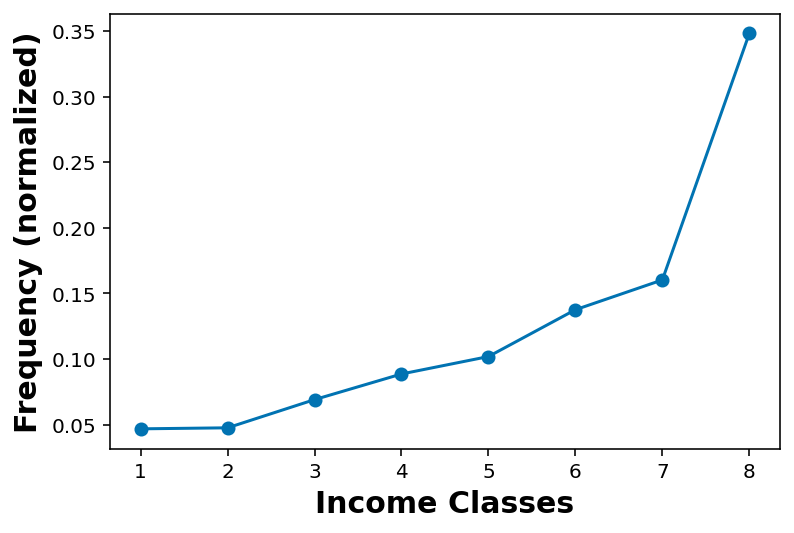

In [52]:
plt.plot(pmf_income[:,0], pmf_income[:,1], marker='o')
plt.xlabel('Income Classes')
plt.ylabel('Frequency (normalized)')

In [53]:
cdf_income = cdf(df_income_no_nan['INCOME2'])

In [54]:
cdf_income

array([[1.        , 0.04685557],
       [2.        , 0.09448516],
       [3.        , 0.16358974],
       [4.        , 0.25222239],
       [5.        , 0.35413472],
       [6.        , 0.49172346],
       [7.        , 0.65200141],
       [8.        , 1.        ]])

Text(0, 0.5, 'Cumulative Frequency (normalized)')

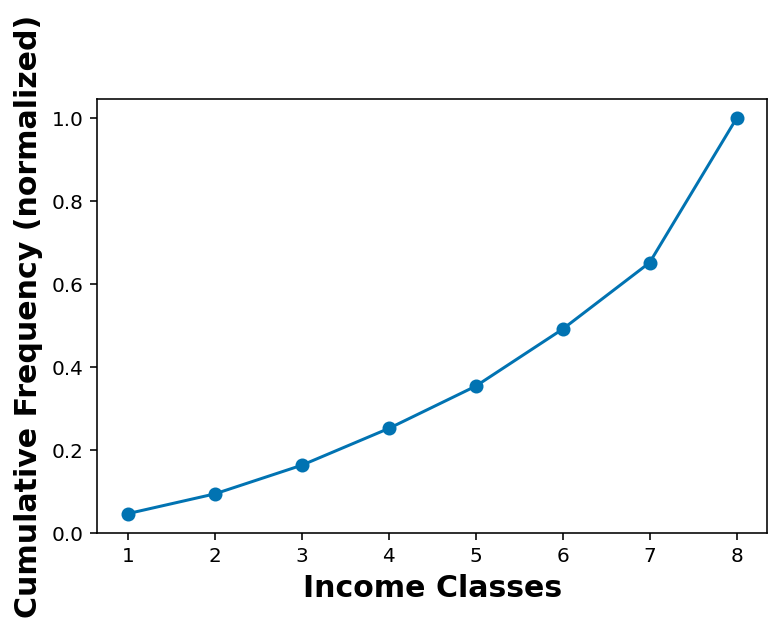

In [55]:
plt.plot(cdf_income[:,0], cdf_income[:,1], marker='o')
plt.xlabel('Income Classes')
plt.ylabel('Cumulative Frequency (normalized)')

Looking at annual income classes as per sex of the respondent 

In [61]:
df_income_no_nan_male = df_income_no_nan.loc[ df_income_no_nan['_SEX'] == 1 ]

In [62]:
df_income_no_nan_female = df_income_no_nan.loc[ df_income_no_nan['_SEX'] == 2 ]

In [63]:
cdf_income_male = cdf(df_income_no_nan_male['INCOME2'])
cdf_income_female = cdf(df_income_no_nan_female['INCOME2'])

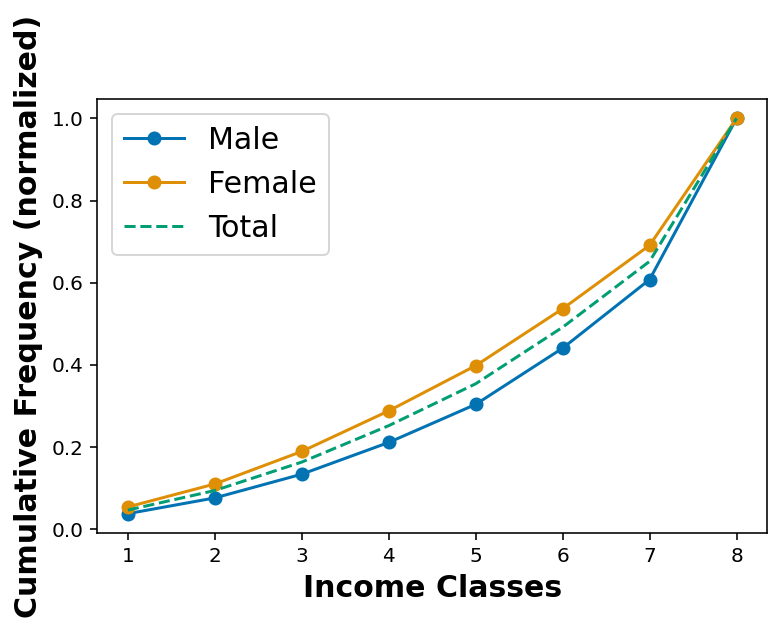

In [64]:
plt.plot(cdf_income_male[:,0], cdf_income_male[:,1], marker='o', label='Male')
plt.plot(cdf_income_female[:,0], cdf_income_female[:,1], marker='o', label='Female')
plt.plot(cdf_income[:,0], cdf_income[:,1], linestyle='--', label='Total')
plt.xlabel('Income Classes')
plt.ylabel('Cumulative Frequency (normalized)')
plt.legend()

**Considering the education level of the respondents**

`EDUCA` What is the highest grade or year of school you completed?

9 and BLANK == Missing and Refused 

`_EDUCAG`  Computed level of education completed categories

In [65]:
df['EDUCA'].value_counts().sort_index()

1.0       619
2.0      9940
3.0     19506
4.0    111890
5.0    116591
6.0    157887
9.0      1809
Name: EDUCA, dtype: int64

In [66]:
df['EDUCA'].replace([9], np.nan, inplace=True)

In [67]:
df['_EDUCAG'].value_counts()

4    157887
3    116591
2    111890
1     30065
9      1835
Name: _EDUCAG, dtype: int64

In [68]:
df['_EDUCAG'].value_counts(normalize=True).sort_index()

1    0.071880
2    0.267508
3    0.278747
4    0.377478
9    0.004387
Name: _EDUCAG, dtype: float64

In [69]:
df_education_no_na = df.dropna(subset = ['EDUCA'])

In [70]:
df_education_no_na.shape

(416433, 343)

In [71]:
df_education_no_na_male = df_education_no_na.loc[ df_education_no_na['_SEX'] == 1 ]
df_education_no_na_female = df_education_no_na.loc[ df_education_no_na['_SEX'] == 2 ]

In [72]:
cdf_educa_male = cdf(df_education_no_na_male['EDUCA'])
cdf_educa_female = cdf(df_education_no_na_female['EDUCA'])

In [73]:
cdf_educa = cdf(df_education_no_na['EDUCA'])

In [74]:
cdf_educa

array([[1.00000000e+00, 1.48643359e-03],
       [2.00000000e+00, 2.53558195e-02],
       [3.00000000e+00, 7.21964878e-02],
       [4.00000000e+00, 3.40883167e-01],
       [5.00000000e+00, 6.20858577e-01],
       [6.00000000e+00, 1.00000000e+00]])

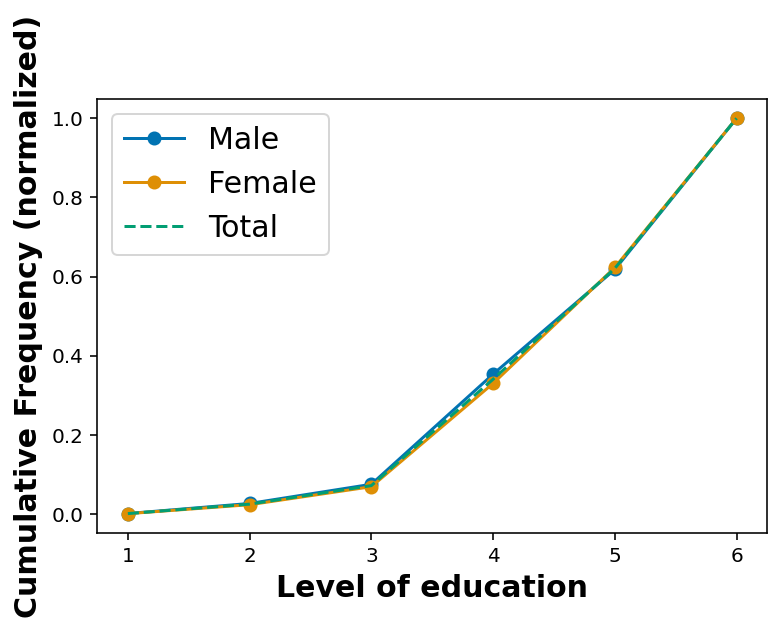

In [76]:
plt.plot(cdf_educa_male[:,0], cdf_educa_male[:,1], marker='o', label='Male')
plt.plot(cdf_educa_female[:,0], cdf_educa_female[:,1], marker='o', label='Female')
plt.plot(cdf_educa[:,0], cdf_educa[:,1], linestyle='--', label='Total')
plt.xlabel('Level of education')
plt.ylabel('Cumulative Frequency (normalized)')
plt.legend()

**Height and Weight**

array([[<AxesSubplot:title={'center':'HTM4'}>]], dtype=object)

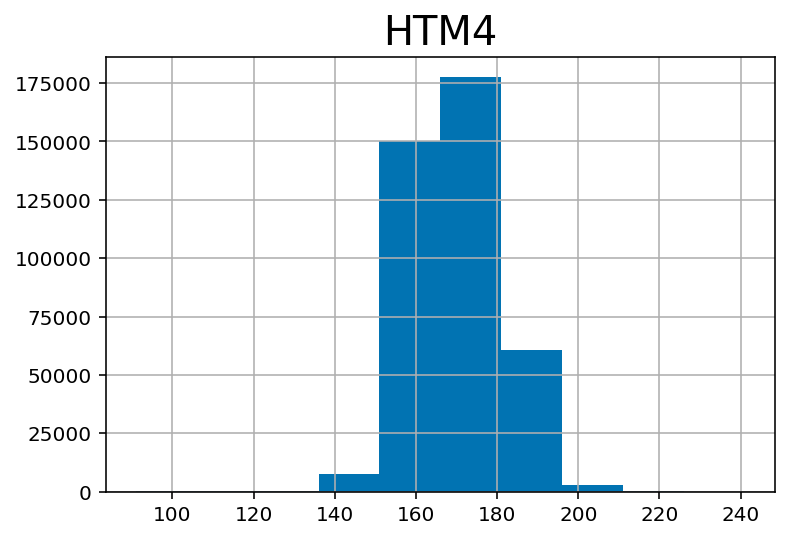

In [80]:
## Height in meters 
df.hist('HTM4')

array([[<AxesSubplot:title={'center':'WTKG3'}>]], dtype=object)

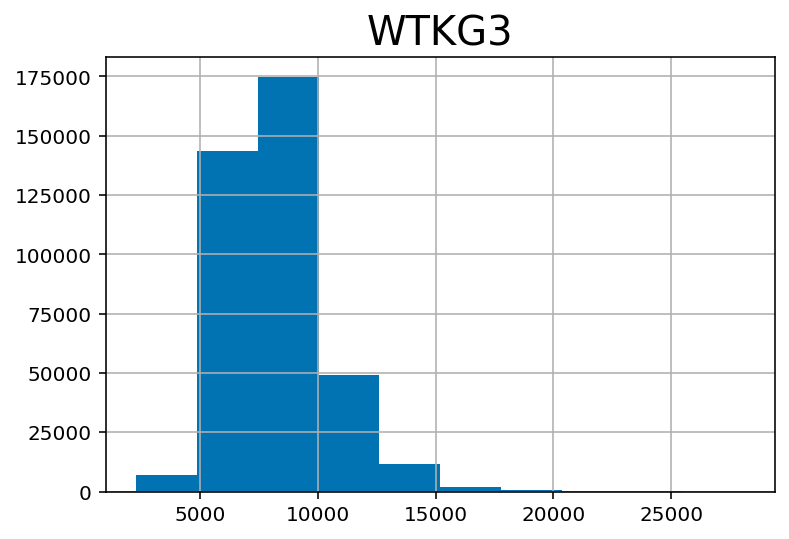

In [82]:
## Weight in kilograms:
df.hist('WTKG3')

In [89]:
df['WTKG3'] = df['WTKG3'] / 100

array([[<AxesSubplot:title={'center':'WTKG3'}>]], dtype=object)

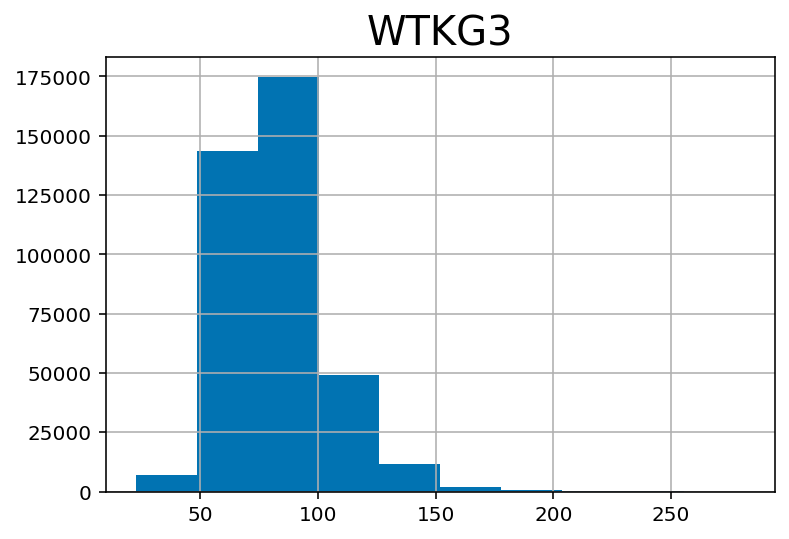

In [90]:
## Weight in kilograms:
df.hist('WTKG3')

In [91]:
wt_male = df.loc[ df['_SEX'] == 1 ]['WTKG3']
wt_female = df.loc[ df['_SEX'] == 2 ]['WTKG3']

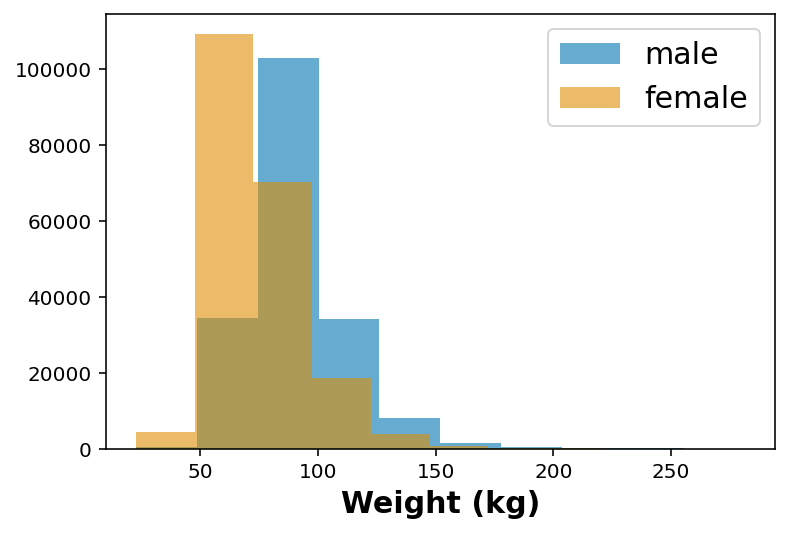

In [97]:
plt.hist(wt_male, alpha=0.6, label='male')
plt.hist(wt_female, alpha=0.6, label='female')
plt.xlabel('Weight (kg)')
plt.legend()

array([[<AxesSubplot:title={'center':'_AGEG5YR'}>]], dtype=object)

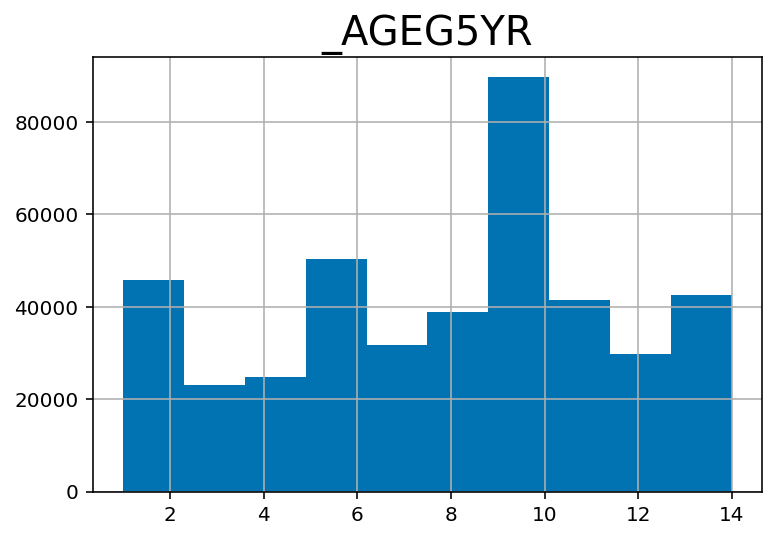

In [98]:
## Age category -- divided in 5 year interval 
df.hist('_AGEG5YR')

### Quick plot for weight vs age-group

In [99]:
## Quick plot for weight as per age 
df_no_nans = df.dropna( subset=['_AGEG5YR', 'WTKG3'] )

Text(0, 0.5, 'Weight (kg)')

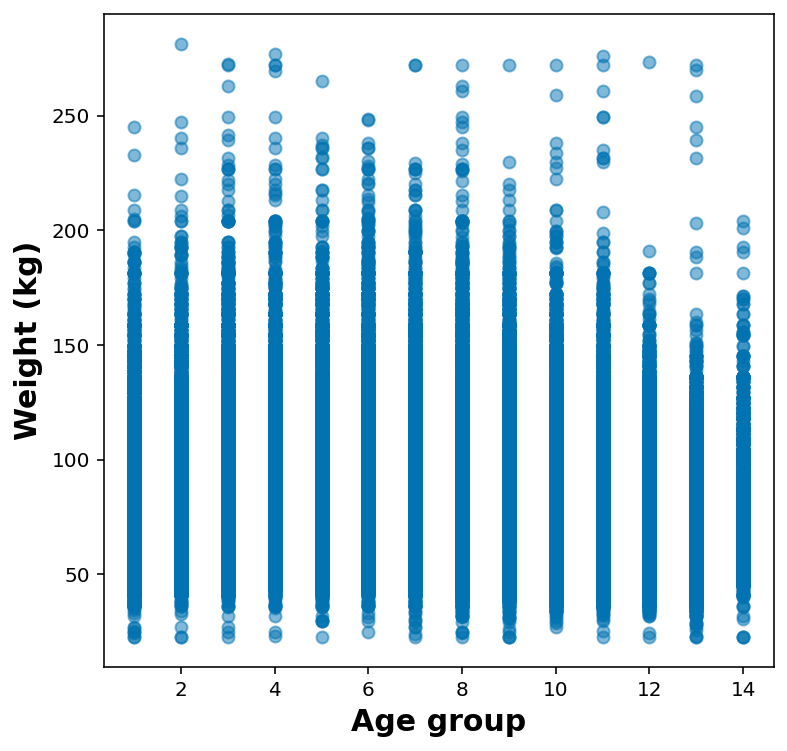

In [100]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter( df_no_nans['_AGEG5YR'], df_no_nans['WTKG3'], marker='o', alpha=0.5)
ax.set_xlabel('Age group')
ax.set_ylabel('Weight (kg)')

It makes much more sense to show these as either violin or box plot:

* Violin plot -- KDE for that column around the y 
Each column is a graphical representation of the distribution of weight in one age group. The width of these shapes is proportional to the estimated density, so it's like two vertical PDFs plotted back to back. 
 
* Box plot -- 
Each box represents the interquartile range, or IQR, from the 25th to the 75th percentile. The line in the middle of each box is the median. The spines sticking out of the top and bottom show the minimum and maximum values. Looking at the medians, it seems like people in their 40s are the heaviest; younger and older people are lighter. Looking at the sizes of the boxes, it seems like people in their 40s have the most variability in weight, too. These plots also show how skewed the distribution of weight is; that is, the heaviest people are much farther from the median than the lightest people.


Text(0, 0.5, 'WEIGHT (Kgs)')

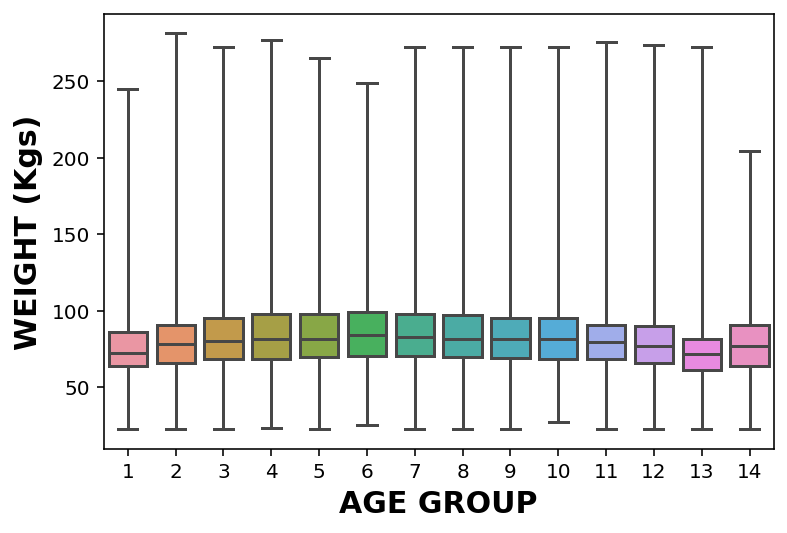

In [101]:
import seaborn as sns
ax = sns.boxplot(x = '_AGEG5YR', y = 'WTKG3', whis=10, data = df_no_nans)
ax.set_xlabel('AGE GROUP')
ax.set_ylabel('WEIGHT (Kgs)')

### Quick plot for height vs weight 

In [106]:
df_height_wt = df.dropna( subset=['HTM4', 'WTKG3'] ).sample(50000)

Text(0, 0.5, 'Weight (kg)')

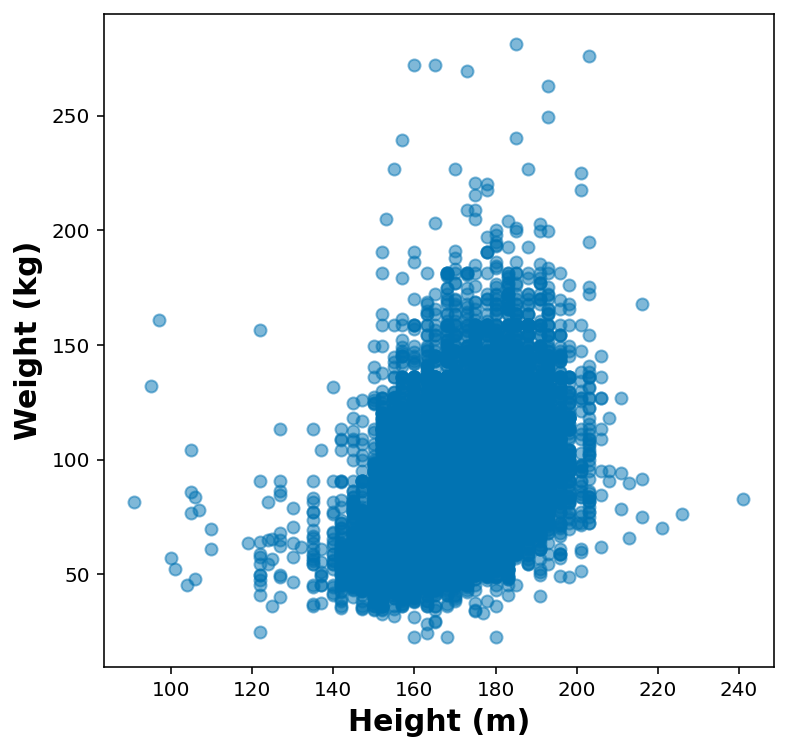

In [107]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter( df_height_wt['HTM4'], df_height_wt['WTKG3'], marker='o', alpha=0.5)
ax.set_xlabel('Height (m)')
ax.set_ylabel('Weight (kg)')

In [108]:
height_jitters = df_height_wt['HTM4'] + np.random.normal(0, 2, size=len(df_height_wt))
weight_jitters = df_height_wt['WTKG3'] + np.random.normal(0, 2, size=len(df_height_wt))

Text(0, 0.5, 'Weight (kg)')

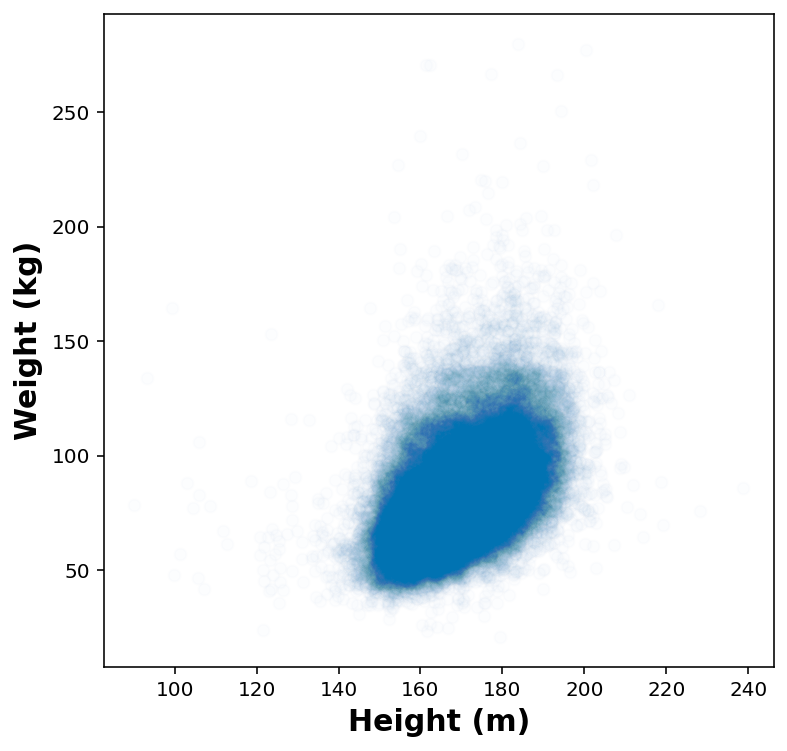

In [109]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter( height_jitters, weight_jitters, marker='o', alpha=0.01)
ax.set_xlabel('Height (m)')
ax.set_ylabel('Weight (kg)')

Fit a linear regression model

In [120]:
from sklearn.linear_model import LinearRegression
x = height_jitters.values.reshape(-1,1)
y = weight_jitters.values.reshape(-1,1)
reg = LinearRegression().fit(x, y)

In [128]:
x.min()

90.14298210689765

In [139]:
print(reg.coef_, reg.intercept_, reg.score(x,y))

[[0.90102916]] [-71.05446729] 0.2163310658640062


In [131]:
height_test = np.linspace(x.min(), x.max()).reshape(-1, 1)

Text(0, 0.5, 'Weight (kg)')

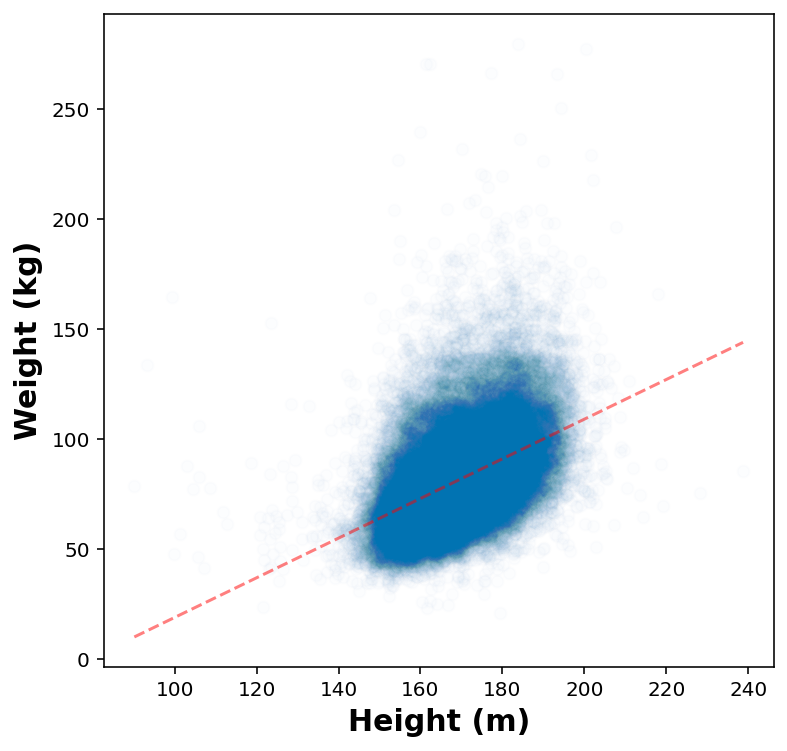

In [134]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot( height_test, reg.predict(height_test), 'r--', alpha=0.5)
ax.scatter( height_jitters, weight_jitters, marker='o', alpha=0.01)
ax.set_xlabel('Height (m)')
ax.set_ylabel('Weight (kg)')